# Frozen Lake: 

*OpenAI gym FrozenLake environment*

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    
    FrozenLake-v0 defines "solving" as getting average reward of 0.78 over 100 consecutive trials.

In [77]:
import numpy as np
import gym
import time 
import matplotlib.pyplot as plt 

# Select our environment & set our seed to 0.
env = gym.make('FrozenLake-v1')
env.seed(0);

### Some Simple Helper Function for plotting results later on.

In [303]:
def movingaverage(interval, window_size=100):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'valid')

def plot_rewards(reward_history, algorithm):
    plt.figure(figsize=(14,6))
    plt.plot(movingaverage(reward_history))

    plt.title(f'{algorithm} Average Total Reward on FrozenLake', fontsize=24)
    plt.ylabel('Average Total reward', fontsize=16, labelpad=10)
    plt.xlabel('Episode Number', fontsize=16, labelpad=10);

### Lets inspect the observation and action space

In [78]:
print(f'The Obsrvation Space is: {env.observation_space}')
print(f'The Action Space is: {env.action_space}')

The Obsrvation Space is: Discrete(16)
The Action Space is: Discrete(4)


In [79]:
print(f'Obsrvation Space Sample: {env.observation_space.sample()}')
print(f'Action Space Sample: {env.action_space.sample()}')

Obsrvation Space Sample: 2
Action Space Sample: 2


### We can also inspect the environment by rendering it

In [111]:
num_steps = 4

obs = env.reset()
for step in range(num_steps):
    # take random action
    action = env.action_space.sample()
    
    # apply the action
    obs, reward, done, info = env.step(action)
    
    # Render the env
    env.render(mode='human')

    # Wait a bit before the next frame 
    time.sleep(1)
    
    # If the epsiode is over, start another one
    if done:
        env.reset()

# Close the env
env.close()

  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


## The below is a general framework we can use to train different RL algorithms.

In [306]:
def train_agent(
    rl_agent,
    env,
    discount_factor,
    learnRate,
    epsilon,
    num_episodes=10_000,
    episode_max_length=100,
    n=250
):    
    agent = rl_agent(
        env.observation_space,
        env.action_space,
        discount_factor,
        learnRate, 
        n
    )
    
    # Keep track of the total reward at the end of each episode.
    reward_history = []

    for i in range(num_episodes):

        # We need to reset the environment at the start of each episode.
        state = env.reset()
        done = False 
        total_reward = 0

        for t in range(episode_max_length):

            # Select an action using an epsilon-greedy Policy.
            action = agent.action(state)            

            # apply the action get new state, reward, done.
            state_next, reward, done, _ = env.step(action)

            # Keep track of the total reward observed
            total_reward += reward

            # Train the RL Agent
            agent.update(state, action, reward, state_next)     

            # Check if we have reached a terminal state 
            if done:
                reward_history.append(total_reward)
                agent.end_episode()
                break

            # update the current state observation and continue with current episode.
            state = state_next

    return reward_history

# Lets start by implimenting the Q-Learning Algorithm. 

In [307]:
class QLearning:
    def __init__(self, 
            observation_space,
            action_space,
            discount_factor,
            learning_rate,
            n=250
        ):
        
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.n = n
        self.episode = 0
        
        self.action_space = action_space
        self.Q_value_table = np.zeros([observation_space.n, action_space.n])
    
    def action(self, state):
        epsilon_i = self.epsilon/max(1, self.episode - self.n + 1)
        
        if np.random.random() < epsilon_i:
            return self.action_space.sample()
        
        return np.argmax(self.Q_value_table[state,:]) 
    
    def update(self, state, action, reward, state_next):
        # Perform the Q-Value Update.
        td_error = (reward + self.discount_factor*max(self.Q_value_table[state_next])) - self.Q_value_table[state][action]
        self.Q_value_table[state][action] += self.learning_rate*td_error
        
    def end_episode(self):
        self.episode += 1

## Finally, lets Train our Agent

In [313]:
discount_factor = 0.99
learning_rate = 0.2
epsilon = 0.9
n = 500

reward_history_QLearning = train_agent(QLearning, env, discount_factor, learning_rate, epsilon, n=n)

## Plot the Performance of Q-Learning

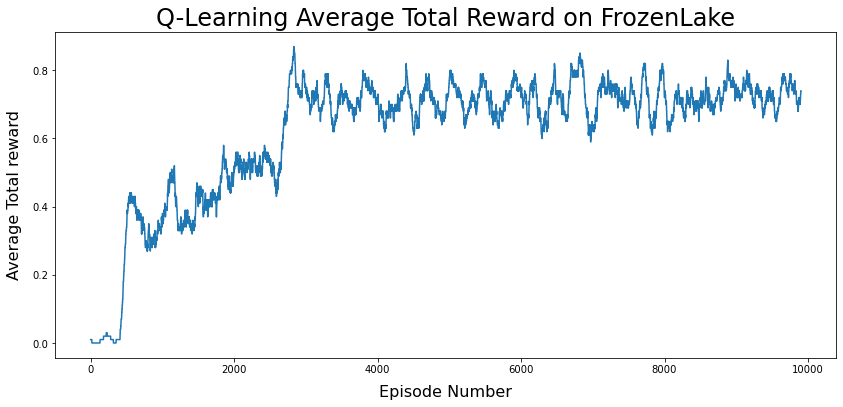

In [314]:
plot_rewards(reward_history_QLearning, 'Q-Learning')

## We can also consider the performance of an On-Policy method, such as (Expected) SARSA 

In [310]:
class SARSA:
    def __init__(self, 
            observation_space,
            action_space,
            discount_factor,
            learning_rate,
            n=250
        ):
        
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.n = n
        self.episode = 0
        
        self.action_space = action_space
        self.Q_value_table = np.zeros([observation_space.n, action_space.n])
        
        self.next_action = None
        
    def action(self, state):
        if self.next_action is not None:
            return self.next_action
        return self._action(state)
    
    def _action(self, state):
        epsilon_i = self.epsilon/max(1, self.episode - self.n + 1)
        
        if np.random.random() < epsilon_i:
            return self.action_space.sample()        
        return np.argmax(self.Q_value_table[state,:]) 
    
    def update(self, state, action, reward, state_next):
        # Select Next Action.
        self.next_action = self._action(state_next)
        
        #compute the TD-Error
        td_error = (
            reward + self.discount_factor*self.Q_value_table[state_next][self.next_action] 
            - self.Q_value_table[state][action]
        )
        
        # Update the Q-Values
        self.Q_value_table[state][action] += self.learning_rate*td_error
        
    def end_episode(self):
        self.episode += 1
        self.next_action = None
        
class ExpectedSARSA(QLearning):
    def __init__(self, observation_space, action_space, discount_factor, learning_rate, n=1000):
        super().__init__(observation_space, action_space, discount_factor, learning_rate, n=1000)
        
    def update(self, state, action, reward, state_next):        
        #compute the TD-Error
        epsilon_i = self.epsilon/max(1, self.episode - self.n + 1)        
        target = (epsilon_i / self.action_space.n)*sum(self.Q_value_table[state_next]) 
        target += (1 - epsilon_i)*max(self.Q_value_table[state_next])
        target = reward + self.discount_factor*target
        
        td_error = target - self.Q_value_table[state][action]
         
        # Update the Q-Values
        self.Q_value_table[state][action] += self.learning_rate*td_error

In [321]:
discount_factor = 0.99
learning_rate = 0.2
epsilon = 0.9
n = 1000

reward_history_QLearning = train_agent(QLearning, env, discount_factor, learning_rate, epsilon, n=n)
reward_history_SARSA = train_agent(SARSA, env, discount_factor, learning_rate, epsilon, n=n)
reward_history_ExpectedSARSA = train_agent(ExpectedSARSA, env, discount_factor, learning_rate, epsilon, n=n)

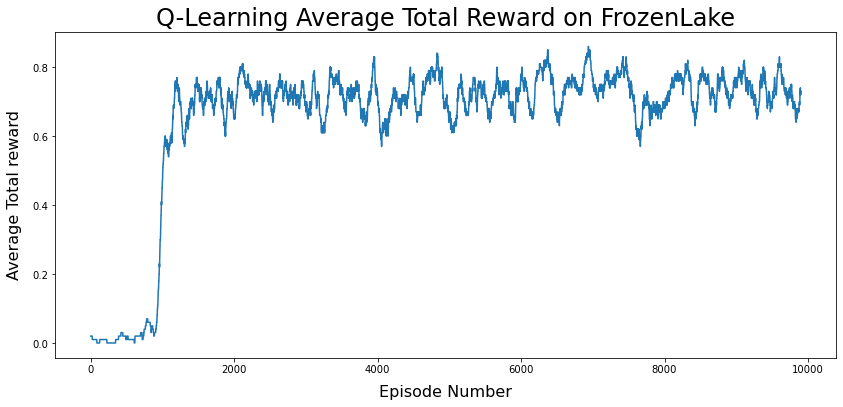

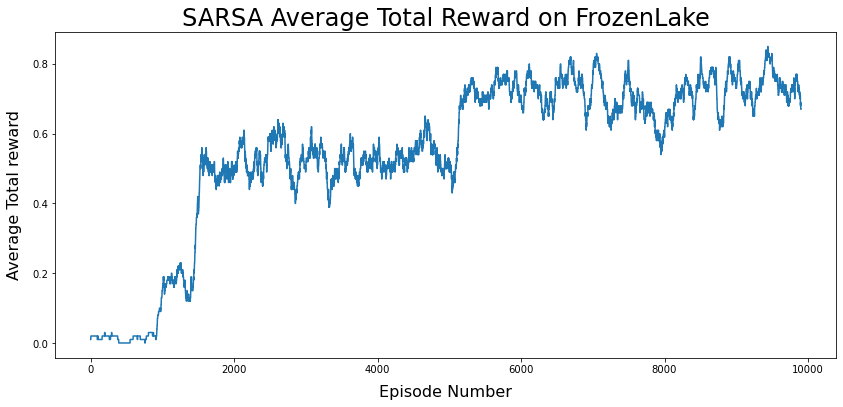

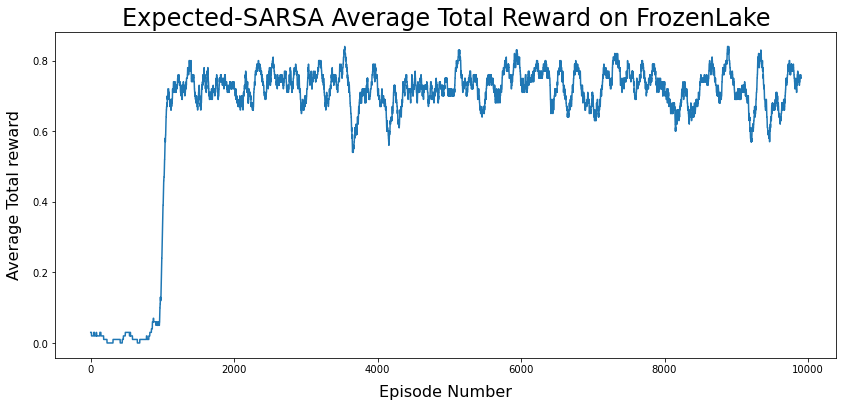

In [322]:
plot_rewards(reward_history_QLearning, 'Q-Learning')
plot_rewards(reward_history_SARSA, 'SARSA')
plot_rewards(reward_history_ExpectedSARSA, 'Expected-SARSA')